# Clustering Geolocation Data Intelligently in Python
We have taxi rank locations, and want to define key clusters of these taxis where we can build service stations for all taxis operating in that region.


In [21]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive

from collections import defaultdict

import hdbscan
import folium
import re


cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10

# Exploratory Data Analysis

In [22]:
df = pd.read_csv('Data/taxi_data.csv')
df.head()

,LON,LAT,NAME
0,28.17858,-25.73882,11th Street Taxi Rank
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank
2,27.83239,-26.53722,Adams Road Taxi Rank
3,28.12514,-26.26666,Alberton City Mall Taxi Rank
4,28.10144,-26.10567,Alexandra Main Taxi Rank


In [23]:
# Check if there is any duplicates
df.duplicated(subset=['LON', 'LAT']).values.any()

True

In [24]:
#check if there is any null value
df.isna().values.any()


True

In [25]:
# print out the shape before dropping df.shape = (838, 3)
print(f'Before dropping NaNs and dupes\t:\tdf.shape = {df.shape}')

Before dropping NaNs and dupes	:	df.shape = (838, 3)


In [26]:
# drop null and duplicates
df.dropna(inplace = True)
df.drop_duplicates(subset = ['LON', 'LAT'], keep='first', inplace = True)

In [27]:
print(f'After dropping NaNs and dupes\t:\tdf.shape = {df.shape}')

After dropping NaNs and dupes	:	df.shape = (823, 3)


In [28]:
# check how dataframe looks like now
df.head()

,LON,LAT,NAME
0,28.17858,-25.73882,11th Street Taxi Rank
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank
2,27.83239,-26.53722,Adams Road Taxi Rank
3,28.12514,-26.26666,Alberton City Mall Taxi Rank
4,28.10144,-26.10567,Alexandra Main Taxi Rank


In [29]:
# extract the longtitude and latitude as a numpy array
lon_lat = np.array(df[['LON', 'LAT']], dtype = 'float64')
lon_lat

array([[ 28.17858, -25.73882],
       [ 28.1766 , -25.73795],
       [ 27.83239, -26.53722],
       ...,
       [ 27.83991, -26.24235],
       [ 27.86166, -26.23624],
       [ 28.39097, -26.30931]])

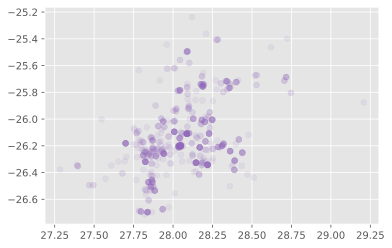

In [30]:
plt.scatter(lon_lat[:,0], lon_lat[:, 1], alpha=0.1, c='#9467bd')

# Task 2: Visualizing Geographical Data

In [88]:
# define a map
original_map = folium.Map(location = [df.LAT.mean(), df.LON.mean()], 
               zoom_start = 9,tiles = 'Stamen Toner')

In [93]:
# iterate through each row in the df to add points
def create_original_map():
    original_map = folium.Map(location = [df.LAT.mean(), df.LON.mean()], 
               zoom_start = 9,tiles = 'Stamen Toner')
    for _, row in df.iterrows():
        folium.CircleMarker(
            location=[row.LAT, row.LON],
            radius = 3,
            popup = re.sub(r'[^a-zA-Z ]+', '', row.NAME),
            color = '#009900',
            fill = True,
            fill_color = '#00cccc').add_to(original_map)
    return original_map
original_map = create_original_map()
original_map.save('original_map.html')

# Task 3: Clustering Strength / Performance Metric

In [34]:
X_blobs, _ = make_blobs(n_samples=1000, 
                        centers=10,
                        n_features=2,
                        cluster_std=0.5,
                        random_state=4)


In [39]:
X_blobs

array([[ -6.89867307,   2.31150542],
       [ -9.73185423,  -2.9970871 ],
       [ -5.37043025,  -1.50923072],
       ...,
       [  9.30620243,  -9.77320382],
       [  4.15014679,  -5.17853902],
       [-10.32190081,  -1.37670435]])

We first don't classify the clusters

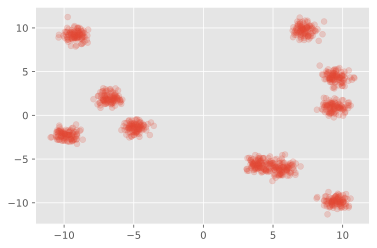

In [35]:
plt.scatter(X_blobs[:,0], X_blobs[:,1], alpha=0.2)

We classify the scatter plots using 3 unique clusters

In [36]:
class_predictions = np.load('Data/sample_clusters.npy')
class_predictions

array([2, 2, 2, 2, 1, 0, 1, 0, 2, 1, 2, 1, 2, 0, 2, 1, 1, 1, 1, 1, 2, 0,
       2, 0, 2, 1, 2, 0, 0, 1, 2, 1, 0, 2, 0, 2, 2, 1, 1, 0, 0, 2, 2, 2,
       2, 1, 2, 1, 0, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 0,
       2, 2, 0, 1, 2, 2, 0, 2, 2, 2, 0, 0, 1, 2, 1, 2, 0, 2, 2, 1, 2, 2,
       1, 2, 2, 0, 2, 1, 2, 2, 1, 0, 2, 2, 2, 0, 1, 0, 1, 2, 0, 0, 2, 2,
       0, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 2, 0, 1, 1, 2, 1, 2, 0, 0,
       2, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 1, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 2, 0, 2, 0, 2,
       2, 0, 1, 2, 1, 1, 2, 0, 1, 1, 2, 1, 2, 0, 2, 1, 0, 2, 2, 2, 0, 2,
       1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 1, 1, 2, 2, 0, 2, 0,
       2, 1, 0, 2, 0, 2, 1, 0, 0, 0, 2, 2, 2, 1, 2, 1, 0, 0, 1, 0, 2, 1,
       1, 2, 0, 2, 0, 2, 2, 1, 0, 0, 0, 1, 1, 2, 1, 1, 0, 0, 1, 0, 2, 2,
       1, 0, 2, 1, 0, 0, 2, 1, 2, 1, 0, 0, 2, 2, 2, 0, 1, 0, 1, 0, 2, 1,
       0, 1, 1, 0, 1, 0, 1, 2, 2, 2, 0, 0, 1, 2, 0,

In [38]:
unique_clusters = np.unique(class_predictions)
unique_clusters

array([0, 1, 2], dtype=int32)

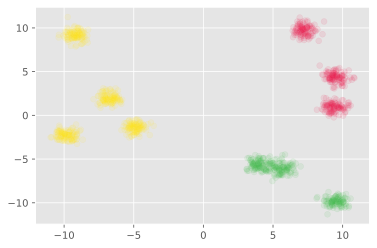

In [41]:
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions == unique_cluster]
    plt.scatter(X[:, 0], X[:, 1], alpha = 0.1, c=cols[unique_cluster])

In [42]:
silhouette_score(X_blobs, class_predictions)

0.6657220862867241

We now classifty the scatter plots using 9 unique clusters

In [44]:
class_predictions_improved = np.load('Data/sample_clusters_improved.npy')
class_predictions_improved

array([1, 6, 7, 7, 4, 3, 2, 3, 5, 4, 6, 2, 5, 0, 1, 9, 2, 2, 9, 9, 6, 0,
       7, 8, 1, 9, 5, 3, 8, 2, 1, 2, 0, 7, 8, 5, 7, 2, 9, 8, 8, 5, 7, 5,
       6, 2, 7, 9, 3, 6, 4, 7, 4, 2, 9, 6, 5, 1, 6, 7, 0, 0, 6, 7, 4, 3,
       7, 6, 8, 4, 5, 5, 3, 7, 6, 1, 3, 8, 9, 5, 9, 7, 8, 1, 1, 4, 5, 7,
       4, 7, 7, 8, 1, 2, 5, 7, 2, 3, 6, 6, 7, 8, 4, 8, 2, 6, 8, 8, 7, 1,
       0, 5, 0, 2, 7, 2, 2, 9, 2, 6, 2, 4, 3, 5, 8, 2, 2, 6, 4, 7, 8, 8,
       7, 0, 4, 4, 3, 6, 3, 3, 8, 8, 1, 9, 0, 6, 6, 7, 7, 3, 3, 1, 0, 5,
       2, 3, 0, 8, 0, 0, 2, 2, 0, 2, 3, 2, 2, 2, 2, 2, 6, 1, 3, 7, 8, 1,
       6, 8, 4, 1, 4, 2, 6, 3, 2, 4, 5, 2, 6, 0, 6, 9, 3, 6, 1, 5, 3, 5,
       4, 5, 7, 6, 4, 5, 5, 4, 5, 5, 7, 0, 2, 1, 7, 9, 2, 6, 6, 0, 1, 0,
       1, 4, 0, 7, 8, 7, 4, 0, 8, 0, 6, 7, 7, 2, 5, 4, 8, 0, 4, 3, 1, 4,
       4, 7, 8, 5, 3, 6, 1, 4, 8, 0, 0, 4, 9, 1, 4, 2, 8, 0, 9, 3, 6, 5,
       4, 0, 6, 2, 3, 0, 1, 2, 5, 9, 8, 0, 7, 1, 7, 0, 9, 0, 4, 0, 7, 9,
       3, 4, 9, 8, 2, 0, 9, 5, 5, 6, 3, 3, 2, 1, 3,

In [48]:
unique_clusters_improved = np.unique(class_predictions_improved)
unique_clusters_improved

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

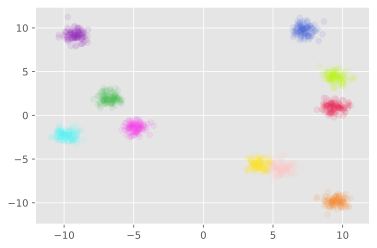

In [46]:
for unique_cluster in unique_clusters_improved:
    X = X_blobs[class_predictions_improved == unique_cluster]
    plt.scatter(X[:, 0], X[:, 1], alpha = 0.1, c=cols[unique_cluster])

Compare to the 3 unique clusters. We can see an extreme improvement.

In [47]:
silhouette_score(X_blobs, class_predictions_improved)

0.7473587799908298

# K-Means Clustering

In [49]:
X_blobs, _ = make_blobs(n_samples=1000, centers=50, 
                        n_features=2, cluster_std=1, random_state=4)

In [50]:
data = defaultdict(dict)
for x in range(1,21):
    model = KMeans(n_clusters=3, random_state=17, 
                   max_iter=x, n_init=1).fit(X_blobs)
    
    data[x]['class_predictions'] = model.predict(X_blobs)
    data[x]['centroids'] = model.cluster_centers_
    data[x]['unique_classes'] = np.unique(class_predictions)

In [51]:
def f(x):
    class_predictions = data[x]['class_predictions']
    centroids = data[x]['centroids']
    unique_classes = data[x]['unique_classes']

    for unique_class in unique_classes:
            plt.scatter(X_blobs[class_predictions==unique_class][:,0], 
                        X_blobs[class_predictions==unique_class][:,1], 
                        alpha=0.3, c=cols[unique_class])
    plt.scatter(centroids[:,0], centroids[:,1], s=200, c='#000000', marker='v')
    plt.ylim([-15,15]); plt.xlim([-15,15])
    plt.title('How K-Means Clusters')

interactive_plot = interactive(f, x=(1, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=10, description='x', max=20, min=1), Output(layout=Layout(height='350px'…

In [53]:
X = np.array(df[['LON', 'LAT']], dtype = 'float64')
k = 70
model = KMeans(n_clusters=k, random_state =17).fit(X)
class_predictions = model.predict(X)
df[f'CLUSTER_kmeans{k}'] = class_predictions

In [54]:
df.head()

,LON,LAT,NAME,CLUSTER_kmeans70
0,28.17858,-25.73882,11th Street Taxi Rank,15
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank,15
2,27.83239,-26.53722,Adams Road Taxi Rank,5
3,28.12514,-26.26666,Alberton City Mall Taxi Rank,33
4,28.10144,-26.10567,Alexandra Main Taxi Rank,18


In [73]:
def create_map(df, cluster_column):
        map = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')

        for _, row in df.iterrows():
            cluster_colour = cols[row[cluster_column]]
            folium.CircleMarker(
                location= [row['LAT'], row['LON']],
                radius=5,
                popup= row[cluster_column],
                color=cluster_colour,
                fill=True,
                fill_color=cluster_colour
            ).add_to(map)
        return map

map = create_map(df, 'CLUSTER_kmeans70')
    
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

map.save('kmeans_70.html')

K=99
Silhouette Score: 0.2992028900672389


In [74]:
best_silhouette, best_k = -1, 0

for k in tqdm(range(2, 100)):
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)
    
    curr_silhouette = silhouette_score(X, class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette
        
print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}') 

100%|██████████| 98/98 [00:21<00:00,  4.48it/s]

K=98
Silhouette Score: 0.6971995093340411


# DBSCAN 
Density-Based Spatial Clustering of Applications with Noise

In [65]:
# code for indexing out certain values
dummy = np.array([-1, -1, -1, 2, 3, 4, 5, -1])
new_dummy = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(dummy)])
new_dummy

array([-2, -3, -4,  2,  3,  4,  5, -9])

In [67]:
model = DBSCAN(eps=0.01, min_samples=5).fit(X)
class_predictions = model.labels_
df['CLUSTER_DBSCAN'] = class_predictions
df.head()

,LON,LAT,NAME,CLUSTER_kmeans70,CLUSTER_DBSCAN
0,28.17858,-25.73882,11th Street Taxi Rank,15,0
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank,15,0
2,27.83239,-26.53722,Adams Road Taxi Rank,5,-1
3,28.12514,-26.26666,Alberton City Mall Taxi Rank,33,-1
4,28.10144,-26.10567,Alexandra Main Taxi Rank,18,1


In [77]:
def create_DBSCAN_map(df, cluster_column):
        map = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')
        for _, row in df.iterrows():
            if row[cluster_column] == -1:
                cluster_colour = '#000000'
            else: 
                cluster_colour = cols[row[cluster_column]]
            folium.CircleMarker(
                location= [row['LAT'], row['LON']],
                radius=5,
                popup= row[cluster_column],
                color=cluster_colour,
                fill=True,
                fill_color=cluster_colour
            ).add_to(map)
        return map

In [78]:
# view the outliers
map = create_DBSCAN_map(df, 'CLUSTER_DBSCAN')
map.save('DBSCAN.html')

In [79]:
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of clusters found: 99
Number of outliers found: 0
Silhouette ignoring outliers: 0.6971082963940812
Silhouette outliers as singletons: 0.6971082963940812


<a id='task6'></a>
# Task 6: HDBSCAN
Hierarchical DBSCAN

In [80]:
model_hdb = hdbscan.HDBSCAN(min_cluster_size = 5,
                                               min_samples = 2,
                                               cluster_selection_epsilon = 0.01)
#min_cluster_size 
#min_samples
#cluster_selection_epsilon

In [83]:
class_predictions = model_hdb.fit_predict(X)
df['CLUSTER_HDBSCAN'] = class_predictions
df.head()

,LON,LAT,NAME,CLUSTER_kmeans70,CLUSTER_DBSCAN,CLUSTER_HDBSCAN
0,28.17858,-25.73882,11th Street Taxi Rank,15,0,19
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank,15,0,19
2,27.83239,-26.53722,Adams Road Taxi Rank,5,-1,-1
3,28.12514,-26.26666,Alberton City Mall Taxi Rank,33,-1,-1
4,28.10144,-26.10567,Alexandra Main Taxi Rank,18,1,55


In [84]:
def create_HDBSCAN_map(df, cluster_column):
        map = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')
        for _, row in df.iterrows():
            if row[cluster_column] == -1:
                cluster_colour = '#000000'
            else: 
                cluster_colour = cols[row[cluster_column]]
            folium.CircleMarker(
                location= [row['LAT'], row['LON']],
                radius=5,
                popup= row[cluster_column],
                color=cluster_colour,
                fill=True,
                fill_color=cluster_colour
            ).add_to(map)
        return map
map = create_HDBSCAN_map(df, 'CLUSTER_HDBSCAN')
map.save('HDBSCAN.html')

In [86]:

print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')


Number of clusters found: 66
Number of outliers found: 102
Silhouette ignoring outliers: 0.7670504356844786
Silhouette outliers as singletons: 0.638992483305273


<a id='task7'></a>
# Task 7: Addressing Outliers


In [96]:
# define the classifier
classifier = KNeighborsClassifier(n_neighbors =1)

In [94]:
# split the dataset
df_train = df[df.CLUSTER_HDBSCAN != -1]
df_test = df[df.CLUSTER_HDBSCAN == -1]

In [105]:
X_train = np.array(df_train[['LON', 'LAT']], dtype = 'float64')
y_train = np.array(df_train['CLUSTER_HDBSCAN'])

X_test = np.array(df_test[['LON', 'LAT']], dtype = 'float64')
y_test = np.array(df_test['CLUSTER_HDBSCAN'], dtype = 'float64')

In [106]:
# fit the classifier
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [107]:
predictions = classifier.predict(X_test)
predictions

array([26, 41, 13, 44, 57, 26, 34,  4, 60, 60, 16, 16, 61, 24, 51, 51, 51,
       58, 41, 63, 13, 45, 15, 45, 45,  6,  0, 17, 26, 26, 26, 49, 49, 53,
       49, 13, 61, 26, 26, 39, 65, 31, 31, 31,  0, 46, 46, 21, 58, 60,  6,
        5, 24,  1, 63, 34, 64, 36, 36, 16,  7,  3, 64, 41, 13, 39, 39, 39,
       41, 40, 40, 25, 59, 57, 61, 61, 62, 26, 15, 15, 59, 63,  6, 19, 61,
       61, 48,  4, 41, 21, 64, 64, 64, 61, 61, 21, 23, 38, 31, 41, 55, 55])

In [108]:
# append to dataframe
df['CLUSTER_hybrid'] = df['CLUSTER_HDBSCAN'] 
df.loc[df.CLUSTER_HDBSCAN == -1, 'CLUSTER_hybrid'] = predictions
df.head(10)

,LON,LAT,NAME,CLUSTER_kmeans70,CLUSTER_DBSCAN,CLUSTER_HDBSCAN,CLUSTER_hybrid
0,28.17858,-25.73882,11th Street Taxi Rank,15,0,19,19
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank,15,0,19,19
2,27.83239,-26.53722,Adams Road Taxi Rank,5,-1,-1,26
3,28.12514,-26.26666,Alberton City Mall Taxi Rank,33,-1,-1,41
4,28.10144,-26.10567,Alexandra Main Taxi Rank,18,1,55,55
5,28.10125,-26.10605,Alexandra Main Taxi Rank,18,1,55,55
6,28.10185,-26.10537,Alexandra Main Taxi Rank,18,1,55,55
7,28.10165,-26.10479,Alexandra Taxi Rank,18,1,55,55
8,28.10151,-26.10594,Alexandra Taxi Rank,18,1,55,55
9,28.10200,-26.10576,Alexandra Taxi Rank,18,1,55,55


In [109]:
map = create_HDBSCAN_map(df, 'CLUSTER_hybrid')
map.save('hybrid.html')

In [111]:
class_predictions = df.CLUSTER_hybrid
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')

Number of clusters found: 66
Silhouette: 0.5849126494706486


Text(0.5, 1.0, 'Comparing hybrid and kmeans70')

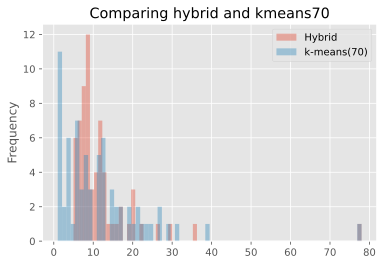

In [113]:
df['CLUSTER_hybrid'].value_counts().plot.hist(bins=70, alpha=0.4, label = 'Hybrid')
df['CLUSTER_kmeans70'].value_counts().plot.hist(bins=70, alpha=0.4, label = 'k-means(70)')
plt.legend()
plt.title('Comparing hybrid and kmeans70')